<a href="https://colab.research.google.com/github/torifinch/TimeSeriesAnalysis/blob/main/Grocery_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corporación Favorita Grocery Sales Forecasting  
## LSTM Model

Creator: Victoria Finch, 2025

XGBoostModel: https://colab.research.google.com/drive/1YxSTFa7mo1HC-wXG-qs3IF5BU7k4X3ax?usp=sharing

##Import Cleaned Data

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

Let's read in the data with all of the features from the last week:

In [24]:
df_train = pd.read_csv('/content/final_train1.csv', on_bad_lines='skip', engine='python')

Note that here for the simplicity sake we read in the data directly from a file. In your case you'll need to read this datafile from a folder in a Google Drive that you saved it to.

In [25]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,oil_price,rolling_mean_7d,rolling_mean_14d,rolling_mean_30d,rolling_std_7d,rolling_std_14d,rolling_std_30d,lag_1,lag_7,lag_14
0,1402408,2013-02-05,24,96995,1.0,0.0,2013,2,5,1,...,96.68,4.714286,5.000000,4.833333,5.219013,5.068758,5.010908,4.0,15.0,2.0
1,4912716,2013-04-29,24,96995,1.0,0.0,2013,4,29,0,...,94.09,4.142857,6.285714,5.566667,4.017817,7.258190,5.928792,5.0,6.0,2.0
2,6945807,2013-06-14,24,96995,3.0,0.0,2013,6,14,4,...,97.83,5.428571,6.071429,5.466667,5.740416,4.937522,4.470079,11.0,2.0,10.0
3,7442322,2013-06-25,24,96995,1.0,0.0,2013,6,25,1,...,95.25,4.571429,12.857143,8.433333,7.161404,21.019614,15.155933,20.0,5.0,4.0
4,8561060,2013-07-20,24,96995,6.0,0.0,2013,7,20,5,...,56.59,7.571429,6.000000,4.866667,6.754187,5.449065,5.250506,3.0,8.0,2.0


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281085 entries, 0 to 1281084
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1281085 non-null  int64  
 1   date                   1281085 non-null  object 
 2   store_nbr              1281085 non-null  int64  
 3   item_nbr               1281085 non-null  int64  
 4   unit_sales             1281085 non-null  float64
 5   onpromotion            1281085 non-null  float64
 6   year                   1281085 non-null  int64  
 7   month                  1281085 non-null  int64  
 8   day                    1281085 non-null  int64  
 9   day_of_week            1281085 non-null  int64  
 10  week_of_year           1281085 non-null  int64  
 11  is_weekend             1281085 non-null  int64  
 12  is_holiday             1281085 non-null  int64  
 13  is_bridge_day          1281085 non-null  int64  
 14  is_day_before_holi

##Removing Null Values


In [27]:
#remove any nulls
df_train = df_train.dropna()

###Smoothing Outliers

In [28]:
from scipy.stats import zscore

# Compute Z-score within each store-item group
df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))

# Flag as outlier
df_train['is_outlier'] = df_train['z_score'].abs() > 5

<ipython-input-28-77ebdffe0c1c>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))
<ipython-input-28-77ebdffe0c1c>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))
<ipython-input-28-77ebdffe0c1c>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: zscore(x, ddof=0))
<ipython-input-28-7

In [29]:
def smooth_outliers(group):
    # Calculate rolling median (can change window size)
    rolling_median = group['unit_sales'].rolling(window=7, center=True, min_periods=1).median()

    # Replace outliers with rolling median
    group.loc[group['is_outlier'], 'unit_sales'] = rolling_median[group['is_outlier']]
    return group

# Apply to each store-item group
df_train = df_train.groupby(['store_nbr', 'item_nbr'], group_keys=False).apply(smooth_outliers)

<ipython-input-29-da6e52ac0eaa>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby(['store_nbr', 'item_nbr'], group_keys=False).apply(smooth_outliers)


Let's again filter out our data by the target time frame: we need all data up to March 2014, including:

In [30]:
max_date = '2014-04-01'
df_train = df_train[(df_train['date'] < max_date)]

In [31]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,rolling_mean_14d,rolling_mean_30d,rolling_std_7d,rolling_std_14d,rolling_std_30d,lag_1,lag_7,lag_14,z_score,is_outlier
0,1402408,2013-02-05,24,96995,1.0,0.0,2013,2,5,1,...,5.000000,4.833333,5.219013,5.068758,5.010908,4.0,15.0,2.0,-0.717620,False
1,4912716,2013-04-29,24,96995,1.0,0.0,2013,4,29,0,...,6.285714,5.566667,4.017817,7.258190,5.928792,5.0,6.0,2.0,-0.717620,False
2,6945807,2013-06-14,24,96995,3.0,0.0,2013,6,14,4,...,6.071429,5.466667,5.740416,4.937522,4.470079,11.0,2.0,10.0,0.642081,False
3,7442322,2013-06-25,24,96995,1.0,0.0,2013,6,25,1,...,12.857143,8.433333,7.161404,21.019614,15.155933,20.0,5.0,4.0,-0.717620,False
4,8561060,2013-07-20,24,96995,6.0,0.0,2013,7,20,5,...,6.000000,4.866667,6.754187,5.449065,5.250506,3.0,8.0,2.0,2.681633,False


#LSTM Model

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_train[['unit_sales']])

In [36]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window_size)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM expects 3D shape


In [37]:
# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Building and Training the LSTM Model


In [38]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 1.5828e-04 - val_loss: 2.8793e-04
Epoch 2/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 1.5434e-04 - val_loss: 2.8793e-04
Epoch 3/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 1.4735e-04 - val_loss: 2.8873e-04
Epoch 4/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 1.5265e-04 - val_loss: 2.8134e-04
Epoch 5/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 1.5129e-04 - val_loss: 2.8585e-04
Epoch 6/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 1.4375e-04 - val_loss: 2.9991e-04
Epoch 7/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 1.5931e-04 - val_loss: 2.9218e-04
Epoch 8/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 1.5165e-04 - val_loss: 2.9013e-04
Epoch 9/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 1.5173e-04 - val_loss: 2.9957e-04
Epoch 10/20
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 1.4933e-04 - val_loss: 2.9921e-04
Epoch 11/20
2984/2984 ━━━━━━━

##Predictions

1492/1492 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


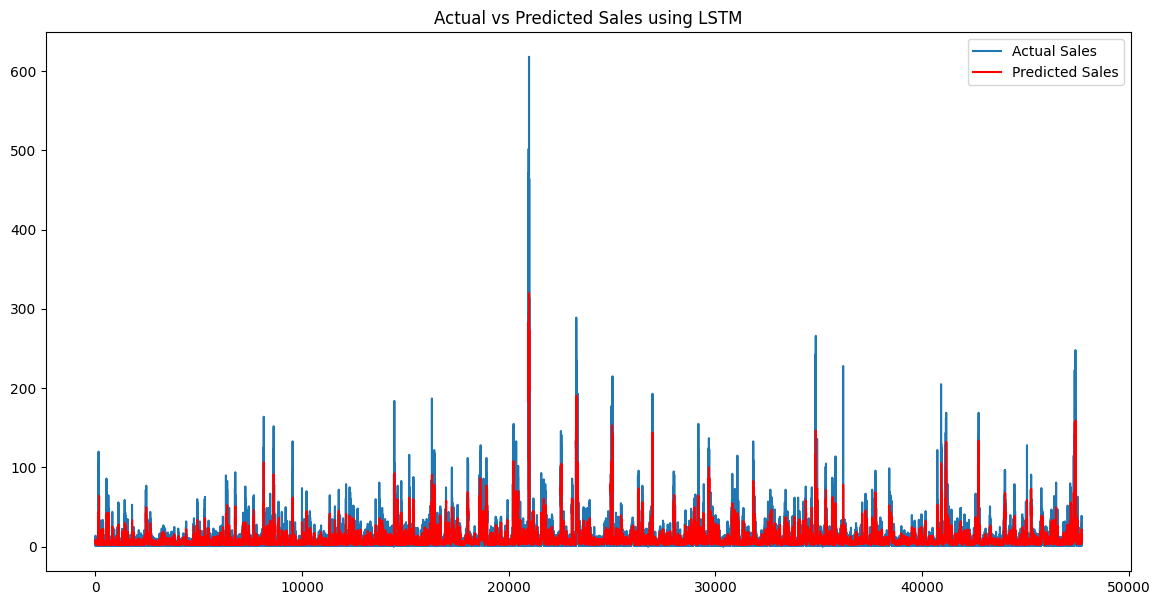

In [41]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

##Metrics & Performance

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
r2 = r2_score(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
mse = mean_squared_error(y_test_scaled, predictions)

# Print metrics
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


R² Score: 0.6329641160159409
Mean Absolute Error (MAE): 5.063358475318254
Mean Squared Error (MSE): 107.94970427306721


These scores are much further off from the target vs our XGBoost Model, but this is the baseline and we will see if they can be improved with Hyperparameter Tuning.

##Hyperparameter Tuning

In [48]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [50]:

# Define model
def build_model(units=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

# Try different parameter combos
model = build_model(units=128, dropout=0.3, lr=0.0005)

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5967/5967 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1.5918e-04 - mae: 0.0064 - val_loss: 3.2368e-04 - val_mae: 0.0082
Epoch 2/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1.5457e-04 - mae: 0.0062 - val_loss: 2.9110e-04 - val_mae: 0.0091
Epoch 3/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 1.5087e-04 - mae: 0.0061 - val_loss: 2.9191e-04 - val_mae: 0.0077
Epoch 4/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 1.4917e-04 - mae: 0.0061 - val_loss: 2.9195e-04 - val_mae: 0.0077
Epoch 5/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1.4850e-04 - mae: 0.0061 - val_loss: 2.8892e-04 - val_mae: 0.0086
Epoch 6/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 1.5248e-04 - mae: 0.0061 - val_loss: 2.8960e-04 - val_mae: 0.0076
Epoch 7/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 1.4142e-04 - mae: 0.0060 - val_loss: 3.1046e-04 - val_mae: 0.0076
Epoch 8/100
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 1.5474e-04 - mae: 0.0061 - val_loss: 2

1492/1492 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


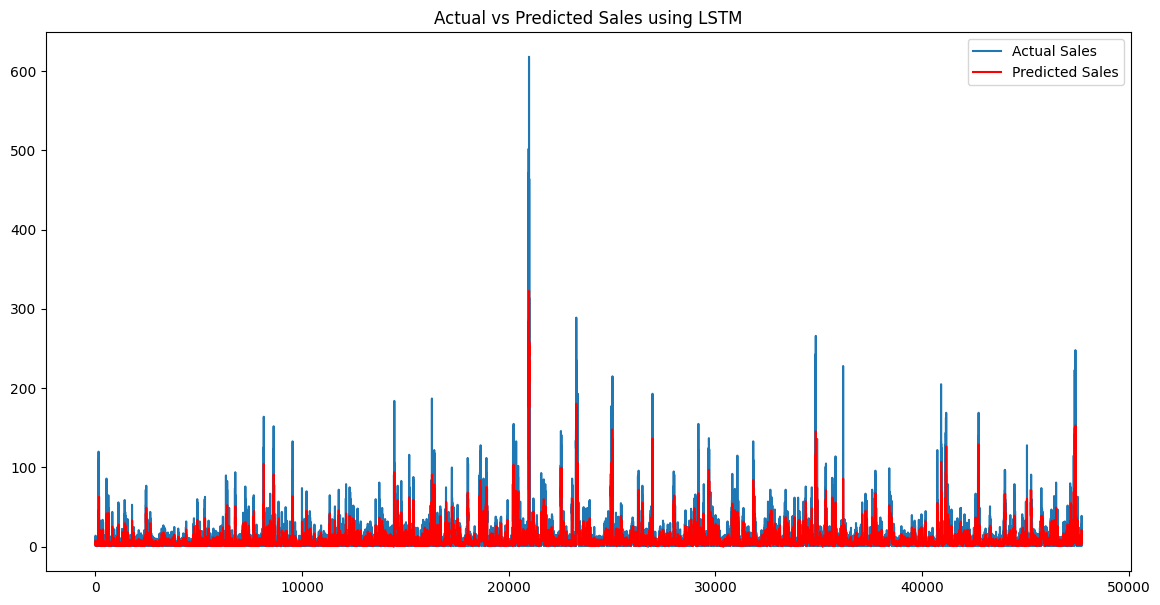

In [51]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

In [52]:
# Calculate metrics
r2 = r2_score(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
mse = mean_squared_error(y_test_scaled, predictions)

# Print metrics
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

R² Score: 0.6335893724666822
Mean Absolute Error (MAE): 4.752320826756254
Mean Squared Error (MSE): 107.76580876884647
